In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold
from IPython.display import SVG

открываем датасет:

In [110]:
df=pd.read_csv("train.csv")
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


Перед просмотром что-там по зависимостям параметров добавим в DF время,ибо это важно,во сколько брали велик,дату сразу дропаем-она ничего не значит:

In [111]:
df['datetime']=pd.to_datetime(df['datetime'])
df['hour'] = df['datetime'].dt.hour
df.drop(['datetime'],axis=1,inplace=True)

Сперва глянем кореляцию и исключим слишком карелирующий с ответом:

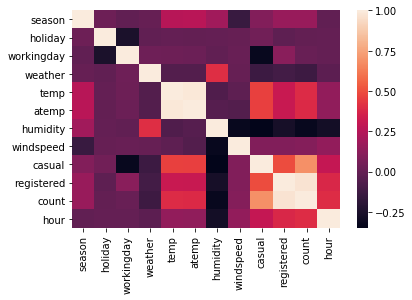

In [112]:
sns.heatmap(df.corr())

temp-atemp-надо дропать что-то,registered-casuas сразу дропаем так как сильно карелирую с counts:

In [113]:
df.drop(['registered','casual'],axis=True,inplace=True)

Хочу попробовать отобрать признаки,базируемся на основе важности,берем DecisionTreeRegressor и глянем,что он скажет по важности параметров:

In [114]:
Y=df['count']
X=df.drop(['count'],axis=1)
Xtrain,Xtest,Ytrain,Ytest=train_test_split(X.values,Y.values,test_size=0.2)

In [115]:
model = DecisionTreeRegressor()
model.fit(Xtrain, Ytrain)
score=model.feature_importances_
for i in range (len(list(X))):
    print(list(X)[i],score[i])

season 0.038278382171835636
holiday 0.00451009286274943
workingday 0.07432013162221246
weather 0.02395425084728754
temp 0.1188693156317993
atemp 0.03285401274874164
humidity 0.07262177197271867
windspeed 0.03756248994917416
hour 0.5970295521934813


Так ну что же,похоже на holiday и weather (в силу кореляции пар-ра с humidity) можно забить сразу и дропнуть их заранее:

In [116]:
df.drop(['holiday','weather'],axis=1,inplace=True)

Взглянем на корреляцию еще разок:

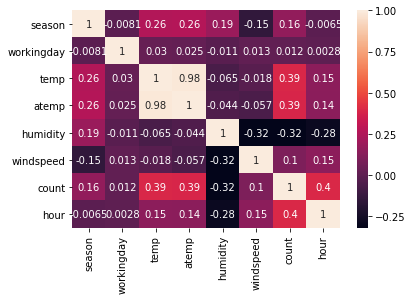

In [117]:
sns.heatmap(df.corr(),annot=True)

temp и atemp (дропнем atemp потому что всё-таки отбор важности сказал,что он чуть-чуть,но важнее):

In [118]:
df.drop(['atemp'],axis=True,inplace=True)

И еще раз смотрим:

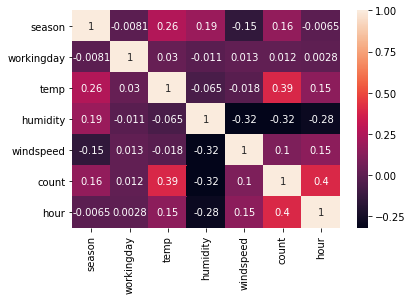

In [119]:
sns.heatmap(df.corr(),annot=True)

Ну вот теперь прямо всё по заданию,еще раз глянем на данные

In [120]:
df.head()

,season,workingday,temp,humidity,windspeed,count,hour
0,1,0,9.84,81,0.0,16,0
1,1,0,9.02,80,0.0,40,1
2,1,0,9.02,80,0.0,32,2
3,1,0,9.84,75,0.0,13,3
4,1,0,9.84,75,0.0,1,4


Начинаем мучать модельку

Сперва нормализуем карелирющие с искомой величиной пар-ры:

 А нафиг? 

 Одно из допущений при работе с моделями,параметры которых оцениваются методом наименьших квадратов-остатки модели независыми т.е.не коррелируют и имеют нормальное распределение со средним значеним 0 и некоторым фикс. стандартным отклонением

In [121]:
scaler = StandardScaler()

In [122]:
scaler.fit_transform(df['temp'].values.reshape(-1, 1))
df['temp'] = scaler.transform(df['temp'].values.reshape(-1, 1))

In [123]:
scaler.fit_transform(df['hour'].values.reshape(-1, 1))
df['hour'] = scaler.transform(df['hour'].values.reshape(-1, 1))

/home/gleb/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/gleb/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/gleb/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [124]:
df.head()

,season,workingday,temp,humidity,windspeed,count,hour
0,1,0,-1.333661,81,0.0,16,-1.668944
1,1,0,-1.438907,80,0.0,40,-1.524341
2,1,0,-1.438907,80,0.0,32,-1.379739
3,1,0,-1.333661,75,0.0,13,-1.235137
4,1,0,-1.333661,75,0.0,1,-1.090534


In [125]:
Y=df['count']
X=df.drop(['count'],axis=1)

Поставим максимальную глубину конечным фиксированным числом,а то без нее ноут умер при отрисовке дерева из svg:

Используем MSE т.к. отрицательные значения не компенсируют положительными и усиливается влияние ошибок, по квадратуре от исходного значения:

и что?

В сравнении с MAE:

1) Подчеркивает большие ошибки над меньшими

2)является дифференцируемой, что позволяет более эффективно использовать для поиска минимальных или максимальных значений с помощью математических методов

In [126]:
tree = DecisionTreeRegressor(max_depth=5,criterion='mse')

In [127]:
x_train, x_val, y_train, y_val = train_test_split(X.values, Y.values, test_size=0.2)

In [128]:
tree.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [129]:
export_graphviz(tree,out_file='tree.dot',feature_names=X.columns, filled=True) 

In [130]:
!dot -Tsvg tree.dot -o tree.svg

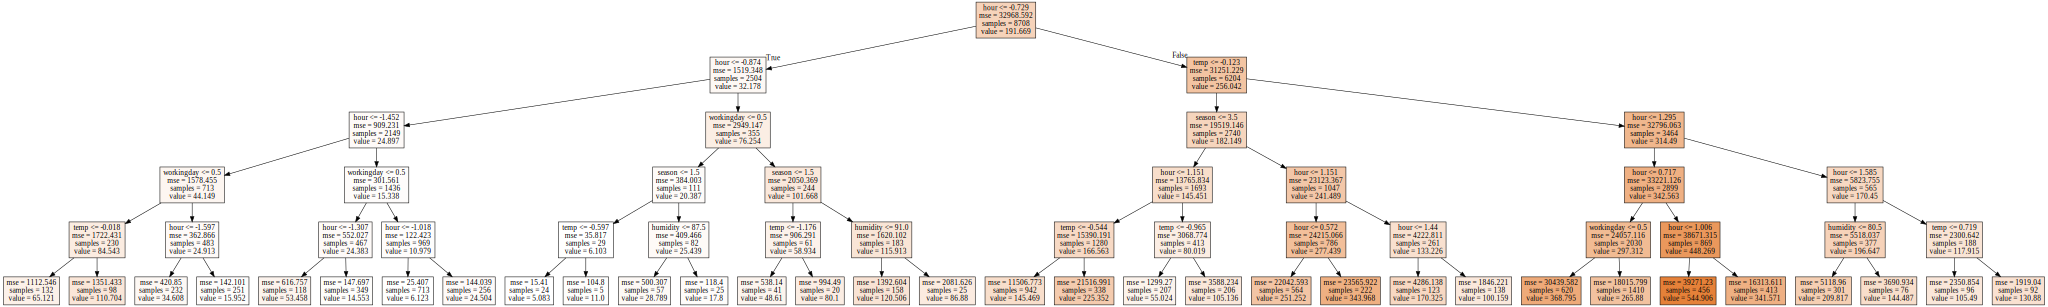

In [131]:
display(SVG('tree.svg'))

In [132]:
r2_score(y_val, tree.predict(x_val))

0.6030057557688292

Как фигово из коробки-то,пора прокачивать параметры коробкой:

In [133]:
tree_params = {'max_depth': range(1,11),'max_features': range(1,6),'min_samples_leaf':range(1,11) }

In [134]:
tree_grid= GridSearchCV(tree, tree_params)

In [135]:
tree_grid.fit(x_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': range(1, 11), 'max_depth': range(1, 11), 'max_features': range(1, 6)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [136]:
tree_grid.best_params_

{'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 8}

In [137]:
tree_grid.best_score_

0.7869526712764446

Ну в целом,уже не так плохо,но хотелось бы по-лучше,покрутим данные с  дерева:

*IN PROGRESS*

# REGRESSION: ( 3 задание)